# **Import data from Kaggle to collab**

In [ ]:

# Make a directory for Kaggle JSON
!mkdir -p ~/.kaggle


# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set proper permissions for the file
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


## **Download BreakHis Data**

In [ ]:
# Download the dataset from Kaggle (replace with your dataset link)
!kaggle datasets download -d ambarish/breakhis



Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
100% 3.97G/3.99G [00:49<00:00, 160MB/s]
100% 3.99G/3.99G [00:49<00:00, 87.1MB/s]


## **UNzip**

In [ ]:
# Unzip the dataset
!unzip breakhis.zip -d breakhis_data


Streaming output truncated to the last 5000 lines.
  inflating: breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-027.png  
  inflating: breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-028.png  
  inflating: breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png  
  inflating: breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-030.png  
  inflating: breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-031.png  
  inflating: breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-032.p

## **Structure the Images in there Corresponding Folders**

In [ ]:
import os
import shutil

# Define the paths
source_dir = "/content/breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
base_dest_dir = "/content/breakhis_classification_data"

# Create destination directories if not exist
if not os.path.exists(base_dest_dir):
    os.makedirs(base_dest_dir)

# Traverse through the source dataset and categorize images into subfolders
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith(".png"):  # Only process image files
            # Check if 'benign' or 'malignant' is in the folder name (this indicates the main class)
            if "benign" in root.lower():
                main_class = "benign"
            elif "malignant" in root.lower():
                main_class = "malignant"
            else:
                continue

            # Extract the subclass name from the folder structure
            # Typically, it should be in a part of the directory path, e.g., adenosis, fibroadenoma, etc.
            subclass = os.path.basename(root).lower()

            # Create a folder path for both main class and subclass
            dest_folder = os.path.join(base_dest_dir, main_class, subclass)

            # Create the subclass folder if it does not exist
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)

            # Move the images into the respective folders
            source_file = os.path.join(root, file)
            shutil.copy(source_file, dest_folder)

print("Images have been successfully organized into subclass folders.")


Images have been successfully organized into subclass folders.


## **Import Library**

In [46]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# **Exploratry Data Analysis**

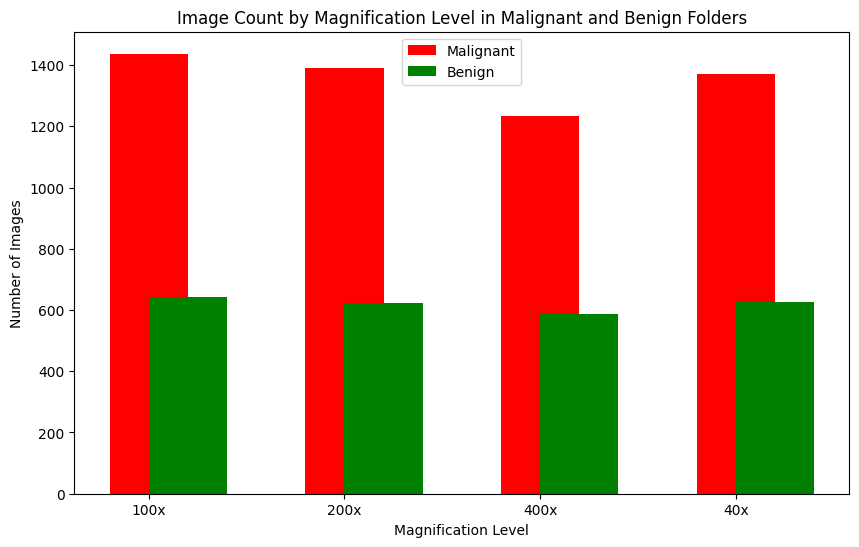

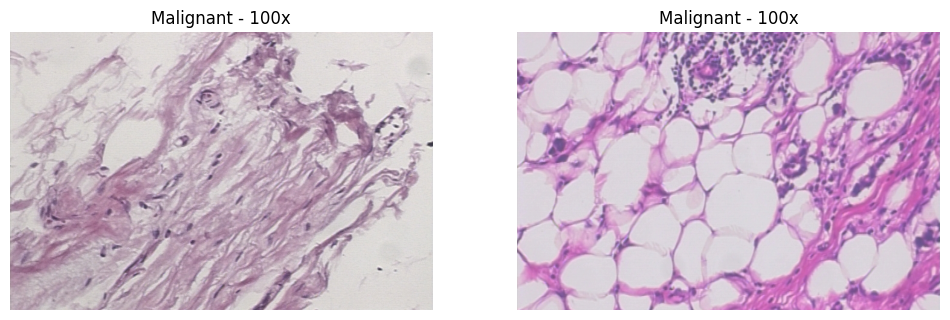

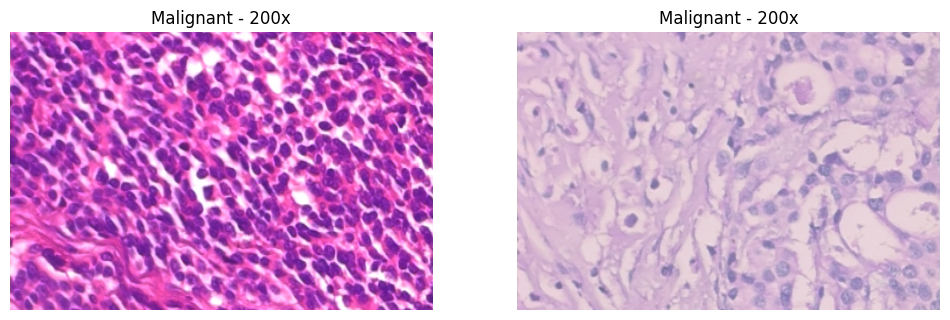

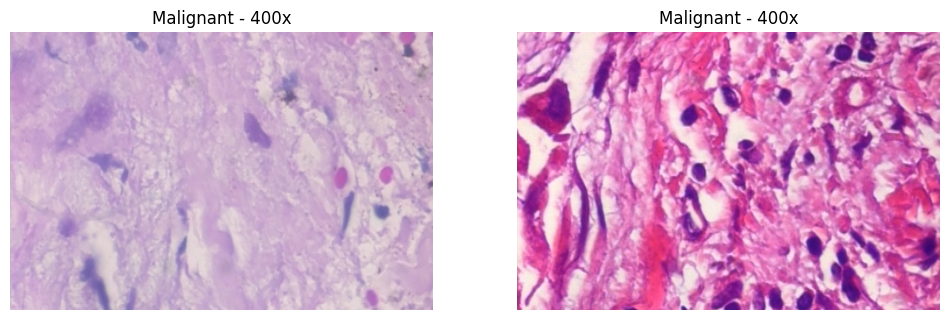

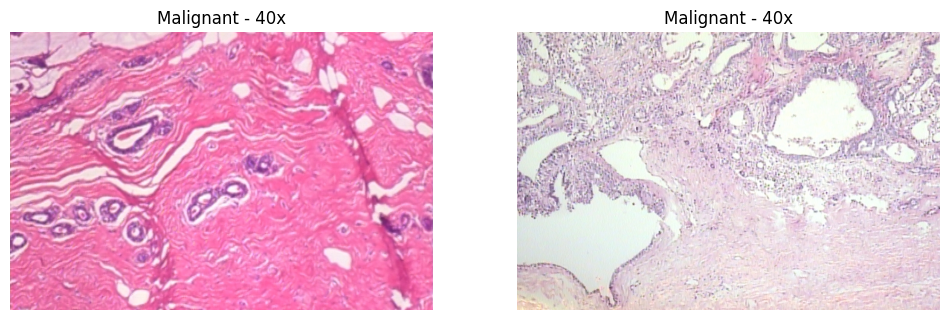

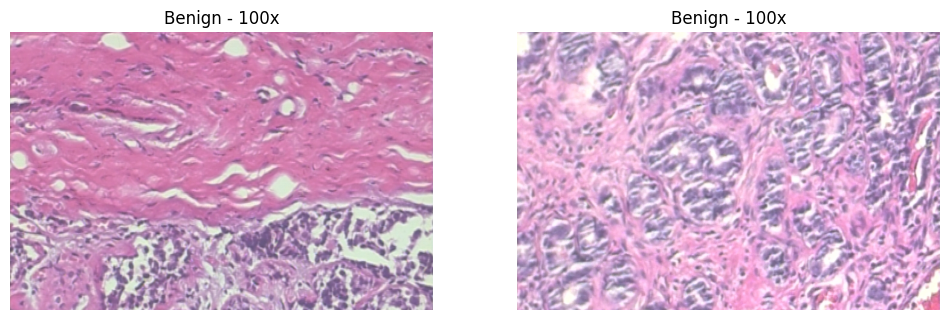

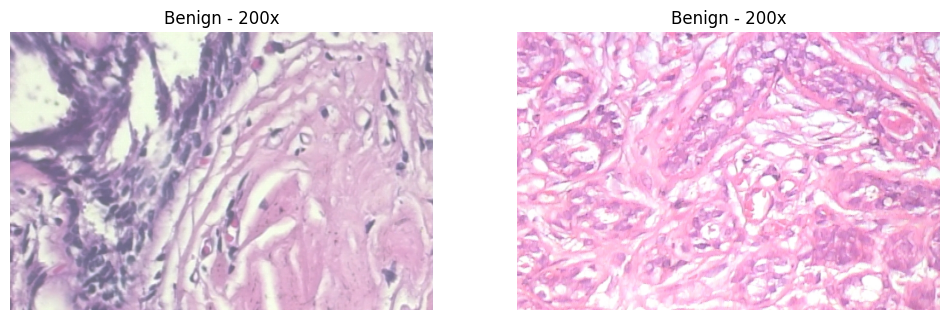

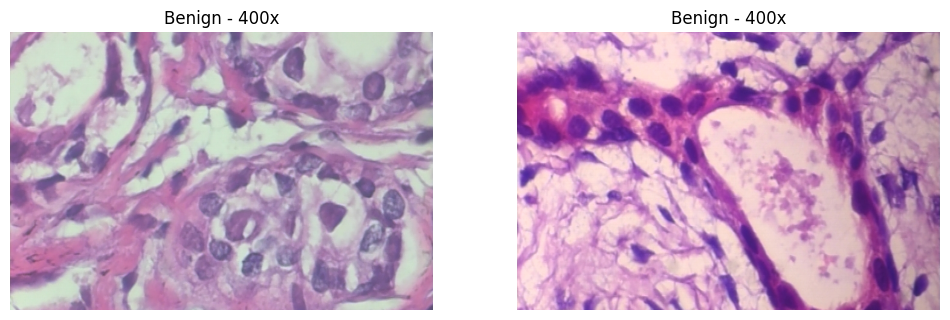

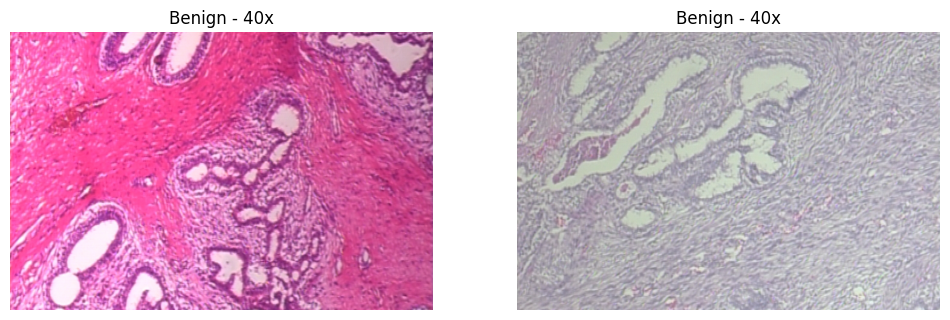

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Paths to dataset
malignant_path = '/content/breakhis_classification_data/malignant'
benign_path = '/content/breakhis_classification_data/benign'

# Function to count images in each subfolder
def count_images_by_magnification(path):
    magnification_counts = {}
    for magnification_folder in os.listdir(path):
        magnification_path = os.path.join(path, magnification_folder)
        if os.path.isdir(magnification_path):
            images = os.listdir(magnification_path)
            magnification_counts[magnification_folder] = len(images)
    return magnification_counts

# Get counts for each magnification level in malignant and benign folders
malignant_counts = count_images_by_magnification(malignant_path)
benign_counts = count_images_by_magnification(benign_path)

# Plotting the counts of images by magnification level
labels = list(malignant_counts.keys())
malignant_vals = list(malignant_counts.values())
benign_vals = list(benign_counts.values())

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, malignant_vals, width=0.4, label='Malignant', color='red', align='center')
plt.bar(x, benign_vals, width=0.4, label='Benign', color='green', align='edge')
plt.xlabel('Magnification Level')
plt.ylabel('Number of Images')
plt.title('Image Count by Magnification Level in Malignant and Benign Folders')
plt.xticks(x, labels)
plt.legend()
plt.show()

# Function to display random images from each magnification level for both classes
def display_random_images_by_magnification(base_path, class_name, num_images=2):
    for magnification_folder in os.listdir(base_path):
        magnification_path = os.path.join(base_path, magnification_folder)
        if os.path.isdir(magnification_path):
            images = os.listdir(magnification_path)
            if len(images) < num_images:
                continue  # Skip if there aren't enough images to display
            selected_images = random.sample(images, num_images)
            plt.figure(figsize=(12, 4))
            for i, img_name in enumerate(selected_images):
                img_path = os.path.join(magnification_path, img_name)
                img = Image.open(img_path)
                plt.subplot(1, num_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'{class_name} - {magnification_folder}')
            plt.show()

# Display random images from each magnification level in malignant and benign folders
display_random_images_by_magnification(malignant_path, 'Malignant')
display_random_images_by_magnification(benign_path, 'Benign')


# **Train Test Split**

In [ ]:

# Paths to dataset
malignant_path = '/content/breakhis_classification_data/malignant/100x'
benign_path = '/content/breakhis_classification_data/benign/100x'

# Function to load images from a given path
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img = img.resize((128, 128))  # Resize images to 128x128
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
        labels.append(label)
    return images, labels

# Load malignant and benign images
malignant_images, malignant_labels = load_images_from_folder(malignant_path, 1)  # Label 1 for malignant
benign_images, benign_labels = load_images_from_folder(benign_path, 0)  # Label 0 for benign


In [ ]:


# Combine the images and labels
X = np.array(malignant_images + benign_images)
y = np.array(malignant_labels + benign_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:


# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)


# **Model Implementation**

## **CNN**

In [ ]:

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

### **Model Training**

In [ ]:


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [45]:



# Start the timer for training
start_time_train = time.time()
# Train the model
history = model.fit(datagen.flow(
    X_train, y_train,batch_size=32),
    validation_data=(X_test, y_test),

    epochs=20
)
# End the timer for training
end_time_train = time.time()

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.8021 - loss: 0.4633 - val_accuracy: 0.8082 - val_loss: 0.4536
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.7683 - loss: 0.4916 - val_accuracy: 0.8465 - val_loss: 0.4343
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.8178 - loss: 0.4367 - val_accuracy: 0.8489 - val_loss: 0.4234
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.8230 - loss: 0.4198 - val_accuracy: 0.8537 - val_loss: 0.4278
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.8182 - loss: 0.4462 - val_accuracy: 0.8513 - val_loss: 0.4301
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.8044 - loss: 0.4598 - val_accuracy: 0.8369 - val_loss: 0.4201
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.8044 - loss: 0.4496 - val_accuracy: 0.8393 - val_loss: 0.4281
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.7958 - loss: 0.4717 - val_accur

### **Model Evalution**

In [49]:

training_time = end_time_train - start_time_train

In [50]:
# Start the timer for testing
start_time_test = time.time()
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')
# End the timer for testing
end_time_test = time.time()
testing_time = end_time_test - start_time_test

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8397 - loss: 0.4303
Test Accuracy: 0.85


In [51]:

print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")

Training time: 250.65 seconds
Testing time: 0.98 seconds


In [52]:

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred_classes))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       135
           1       0.88      0.90      0.89       282

    accuracy                           0.85       417
   macro avg       0.83      0.82      0.82       417
weighted avg       0.84      0.85      0.85       417



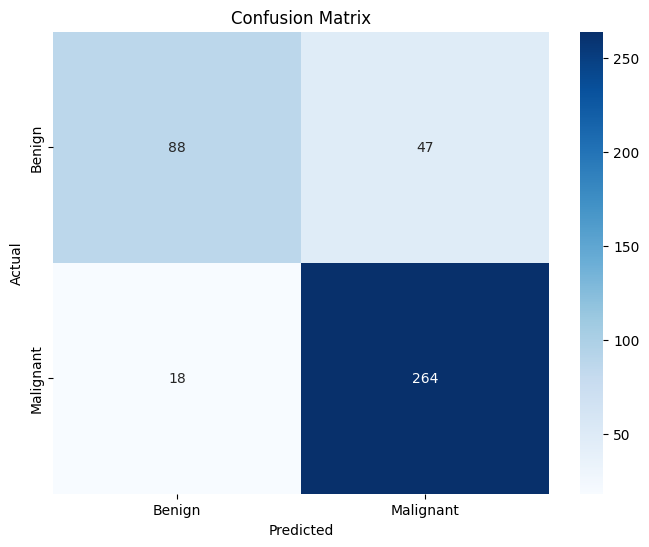

In [ ]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

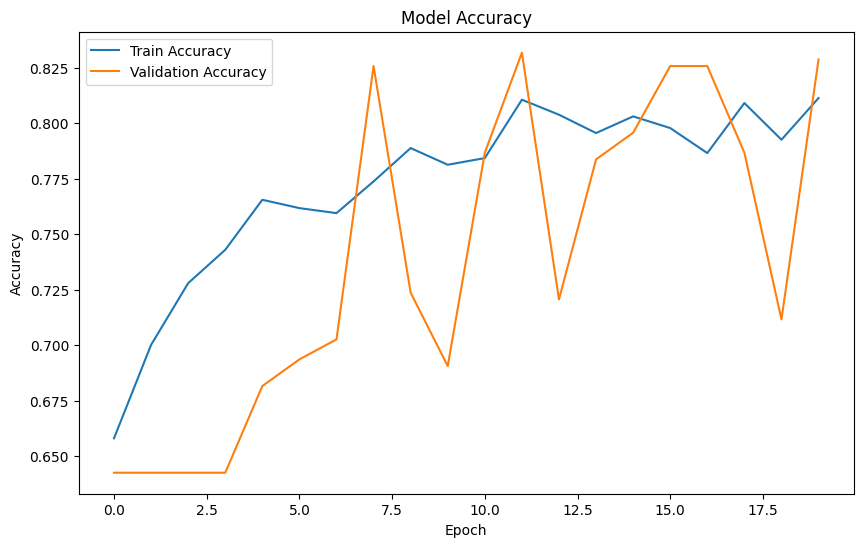

In [ ]:



# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


## **VGG16**

In [36]:
# Define VGG16 model for 128x128 input with fine-tuning
def create_vgg16(input_shape=(128, 128, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Allow fine-tuning

    # Freeze all layers except the last 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Use base model
    x = GlobalAveragePooling2D()(x)         # Pooling layer
    x = Dense(256, activation='relu')(x)    # Fully connected layer
    x = Dropout(0.2)(x)                     # Regularization
    outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for fine-tuning
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and compile the fine-tuned VGG16 model
vgg16_model = create_vgg16()


### **Model Training**

In [53]:
# Start the timer for training
start_time_train = time.time()

# Train the VGG16 model
history = vgg16_model.fit(datagen.flow(
    X_train, y_train,batch_size=32),
    validation_data=(X_test, y_test),

    epochs=20
)

# End the timer for training
end_time_train = time.time()
training_time = end_time_train - start_time_train

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9832 - loss: 0.0383 - val_accuracy: 0.9209 - val_loss: 0.2909
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9841 - loss: 0.0487 - val_accuracy: 0.9017 - val_loss: 0.4474
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9901 - loss: 0.0344 - val_accuracy: 0.8993 - val_loss: 0.5329
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.9727 - loss: 0.0769 - val_accuracy: 0.9113 - val_loss: 0.4062
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9858 - loss: 0.0408 - val_accuracy: 0.9209 - val_loss: 0.4838
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9921 - loss: 0.0289 - val_accuracy: 0.9065 - val_loss: 0.5717
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.9815 - loss: 0.0481 - val_accuracy: 0.9257 - val_loss: 0.3632
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.9764 - loss: 0.0761 - val_accuracy: 0.9305 

### **Model Evalution**

In [54]:
# Start the timer for testing
start_time_test = time.time()
# Evaluate the model
loss, accuracy = vgg16_model.evaluate(X_test, y_test)
print(f'VGG16 Test Accuracy: {accuracy:.2f}')
# End the timer for testing
end_time_test = time.time()
testing_time = end_time_test - start_time_test

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8901 - loss: 0.5258
VGG16 Test Accuracy: 0.89


In [55]:

print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")

Training time: 250.96 seconds
Testing time: 1.41 seconds


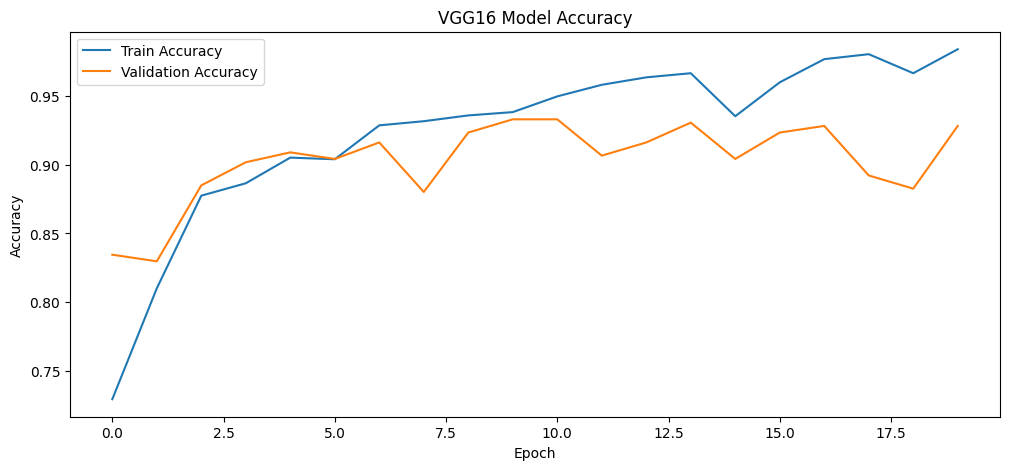

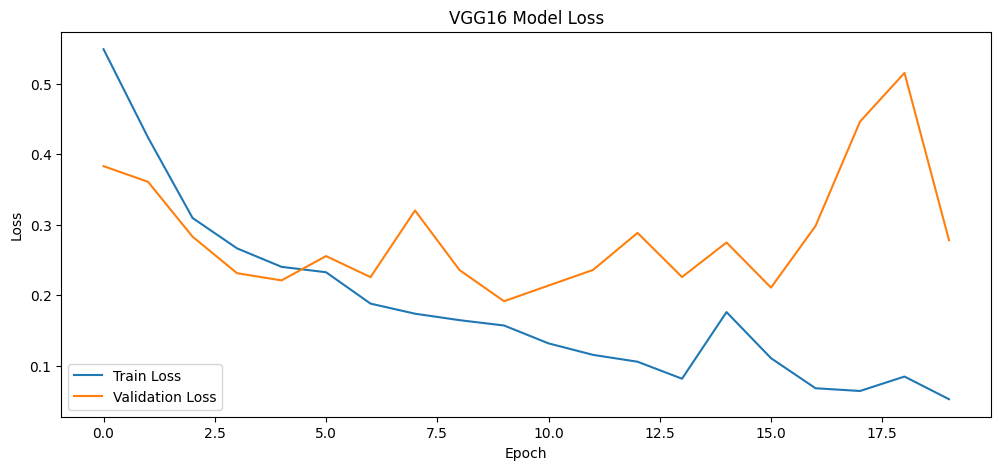

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step

VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       135
           1       0.93      0.97      0.95       282

    accuracy                           0.93       417
   macro avg       0.93      0.91      0.92       417
weighted avg       0.93      0.93      0.93       417



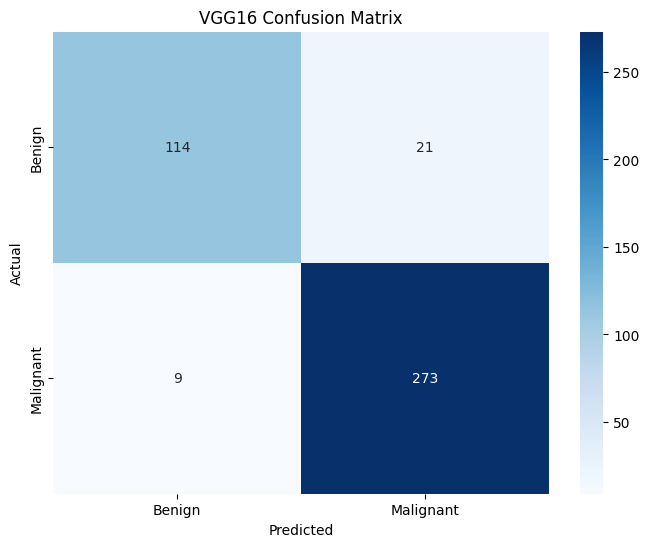

In [40]:

# Metrics and plots
def plot_metrics(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion matrix and classification report
    y_pred = (vgg16_model.predict(X_test) > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Plot metrics
plot_metrics(history, "VGG16")

## **ResNet50**

In [56]:


def create_resnet50(input_shape=(128, 128, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Unfreeze the base model
    # Freeze all layers up to the last 20 layers, for example
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)  # Increased dropout to avoid overfitting
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create and compile the ResNet50 model
resnet50_model = create_resnet50()


### **Model Training**

In [57]:
# Start the timer for training
start_time_train = time.time()
# Train ResNet50 model
resnet50_history = resnet50_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      validation_data=(X_test, y_test),
                                      epochs=20)

# End the timer for training
end_time_train = time.time()
training_time = end_time_train - start_time_train

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 267ms/step - accuracy: 0.6822 - loss: 0.6179 - val_accuracy: 0.6763 - val_loss: 0.6303
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.6831 - loss: 0.6181 - val_accuracy: 0.6763 - val_loss: 0.6304
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.7045 - loss: 0.5797 - val_accuracy: 0.6763 - val_loss: 0.6318
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6717 - loss: 0.5982 - val_accuracy: 0.6763 - val_loss: 0.6303
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.7052 - loss: 0.5596 - val_accuracy: 0.6763 - val_loss: 0.6312
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.7079 - loss: 0.5605 - val_accuracy: 0.6787 - val_loss: 0.6411
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.7231 - loss: 0.5445 - val_accuracy: 0.6763 - val_loss: 0.6017
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.7499 - loss: 0.5167 - val_accurac

### **Model Evalution**

In [58]:
# Start the timer for testing
start_time_test = time.time()
# Evaluate the model
loss, accuracy = resnet50_model.evaluate(X_test, y_test)
print(f'RestNet Test Accuracy: {accuracy:.2f}')
# End the timer for testing
end_time_test = time.time()
testing_time = end_time_test - start_time_test

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6590 - loss: 0.6044
RestNet Test Accuracy: 0.68


In [59]:

print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")

Training time: 216.47 seconds
Testing time: 1.04 seconds


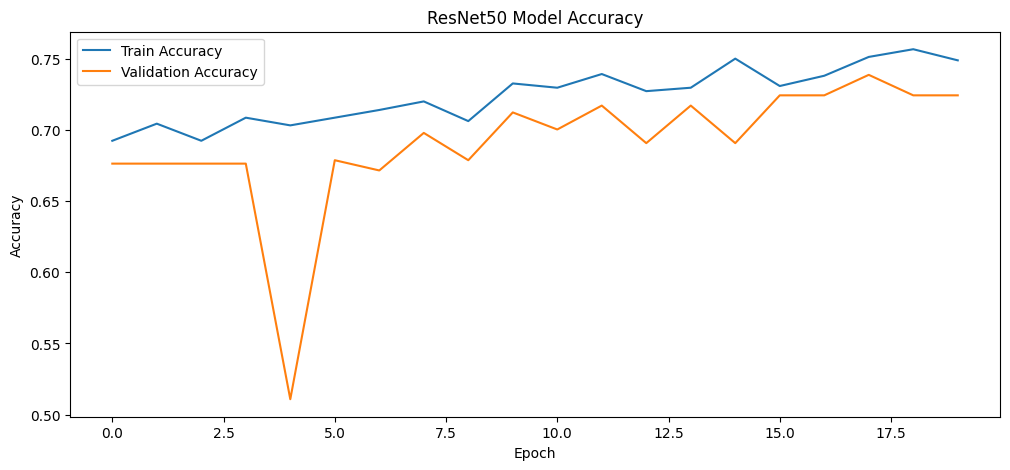

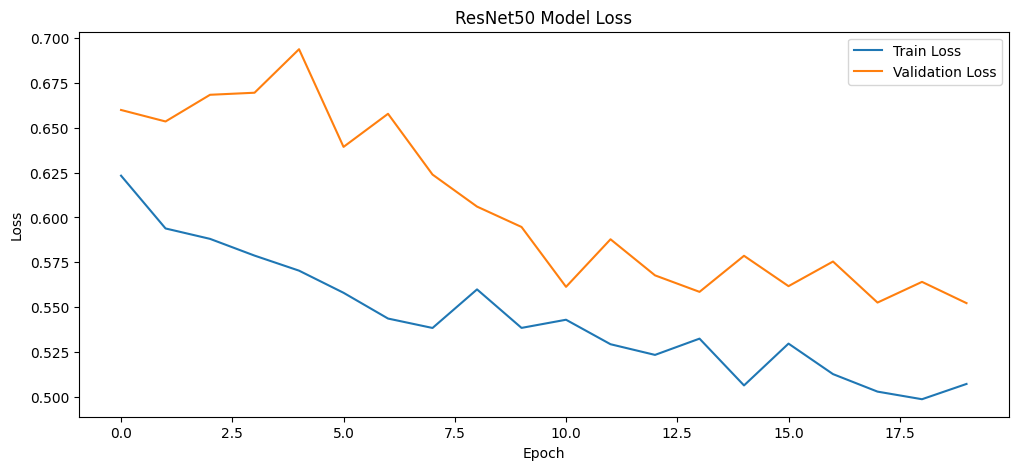

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot metrics
def plot_metrics(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot metrics for ResNet50
plot_metrics(resnet50_history, "ResNet50")


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step

<Functional name=functional_6, built=True> Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.33      0.43       135
           1       0.74      0.91      0.82       282

    accuracy                           0.72       417
   macro avg       0.69      0.62      0.63       417
weighted avg       0.71      0.72      0.69       417



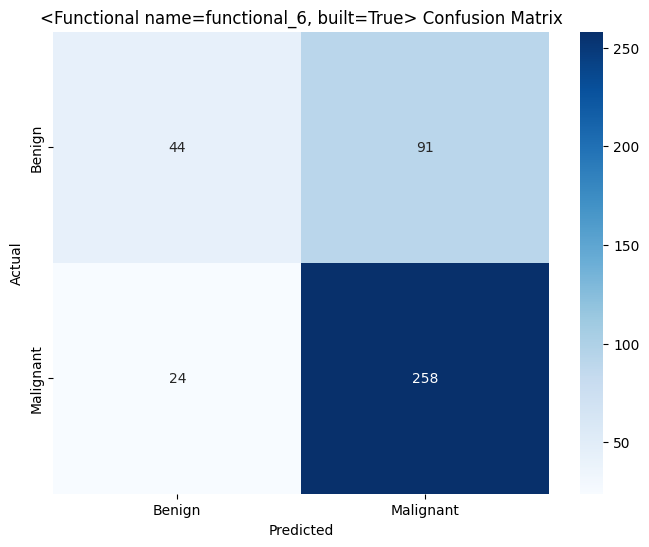

In [ ]:
# Confusion matrix and classification report

y_pred = (resnet50_model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
print(f"\n{resnet50_model} Classification Report:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'{resnet50_model} Confusion Matrix')
plt.show()


## **MobileNet**

In [60]:


def create_mobilenet(input_shape=(128, 128, 3)):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [61]:
model_mobilenet=create_mobilenet()

### **Model Training**

In [62]:
# End the timer for training
end_time_train = time.time()
training_time = end_time_train - start_time_train

# Train the model
history_mobilenet = model_mobilenet.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      validation_data=(X_test, y_test),
                                      epochs=20)

# End the timer for training
end_time_train = time.time()
training_time = end_time_train - start_time_train

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.7023 - loss: 0.6340 - val_accuracy: 0.7962 - val_loss: 0.4526
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.8175 - loss: 0.4161 - val_accuracy: 0.8537 - val_loss: 0.3704
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.8347 - loss: 0.3732 - val_accuracy: 0.8753 - val_loss: 0.3389
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.8734 - loss: 0.3432 - val_accuracy: 0.8585 - val_loss: 0.3325
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.8383 - loss: 0.3568 - val_accuracy: 0.8369 - val_loss: 0.3689
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.8538 - loss: 0.3381 - val_accuracy: 0.8801 - val_loss: 0.2976
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8867 - loss: 0.2866 - val_accuracy: 0.8657 - val_loss: 0.3161
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.8865 - loss: 0.2542 - val_accuracy

### **Model Evalution**

In [63]:
# Start the timer for testing
start_time_test = time.time()
# Evaluate the model
loss, accuracy = model_mobilenet.evaluate(X_test, y_test)
print(f'MObilenet Test Accuracy: {accuracy:.2f}')
# End the timer for testing
end_time_test = time.time()
testing_time = end_time_test - start_time_test

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8637 - loss: 0.3785
MObilenet Test Accuracy: 0.87


In [64]:

print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")

Training time: 398.09 seconds
Testing time: 0.89 seconds


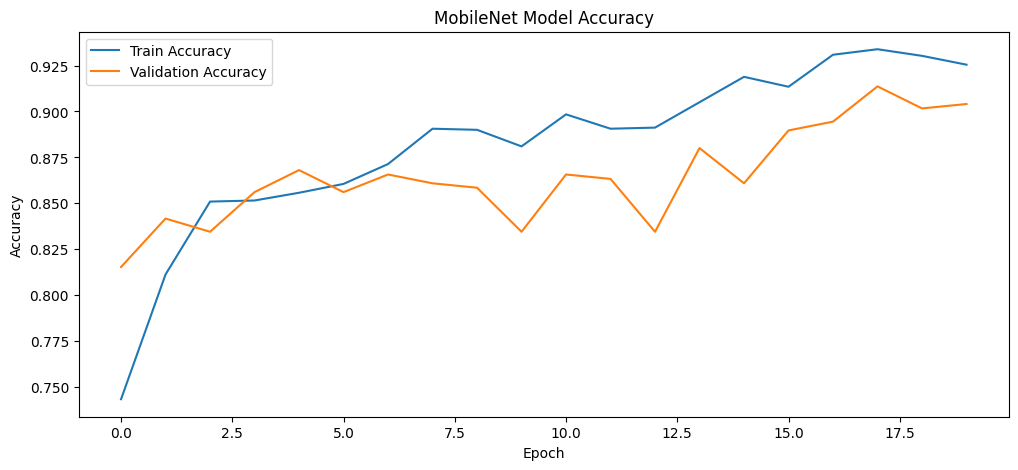

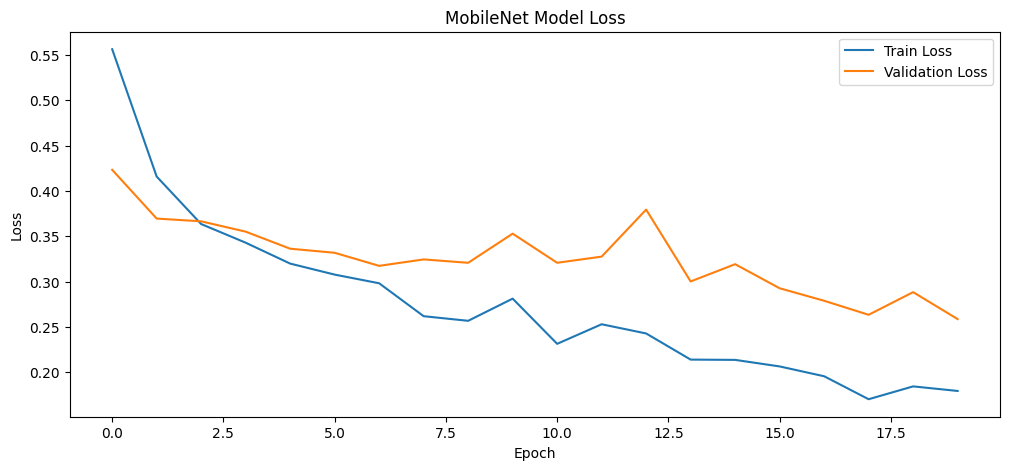

In [ ]:
plot_metrics(history_mobilenet, "MobileNet")


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step

<Functional name=functional_7, built=True> Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       135
           1       0.94      0.92      0.93       282

    accuracy                           0.90       417
   macro avg       0.89      0.89      0.89       417
weighted avg       0.90      0.90      0.90       417



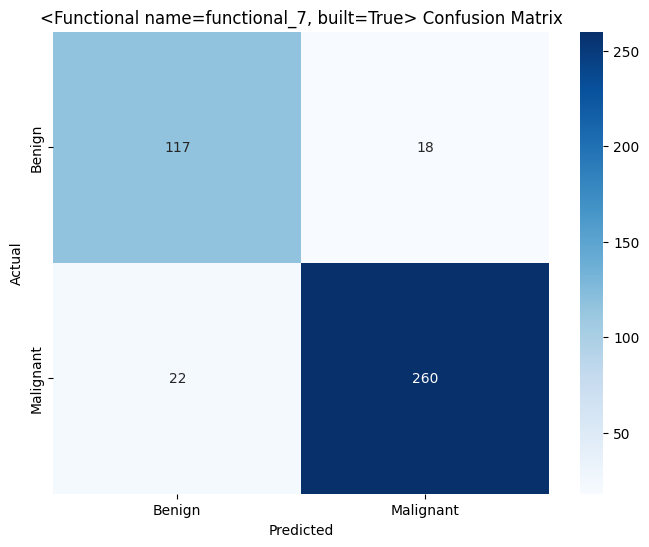

In [ ]:
# Confusion matrix and classification report
y_pred = (model_mobilenet.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
print(f"\n{model_mobilenet} Classification Report:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'{model_mobilenet} Confusion Matrix')
plt.show()

# **Model Implementation**

## **CNN**

In [ ]:

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Model Training**

In [ ]:


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5991 - loss: 6.3057 - val_accuracy: 0.6426 - val_loss: 0.7297
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7110 - loss: 0.6228 - val_accuracy: 0.6426 - val_loss: 0.5480
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7084 - loss: 0.5436 - val_accuracy: 0.6426 - val_loss: 0.5527
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7247 - loss: 0.5123 - val_accuracy: 0.6517 - val_loss: 0.5425
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7428 - loss: 0.5530 - val_accuracy: 0.6426 - val_loss: 0.5798
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6984 - loss: 0.5398 - val_accuracy: 0.6426 - val_loss: 0.5600
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7198 - loss: 0.5173 - val_accuracy: 0.6426 - val_loss: 0.5814
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7119 - loss: 0.5583 - val_accuracy: 0.6426 - v

### **Model Evalution**

In [ ]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7534 - loss: 0.7100
Test Accuracy: 0.78


In [ ]:

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred_classes))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

           0       0.81      0.44      0.57       135
           1       0.78      0.95      0.86       282

    accuracy                           0.78       417
   macro avg       0.79      0.69      0.71       417
weighted avg       0.79      0.78      0.76       417



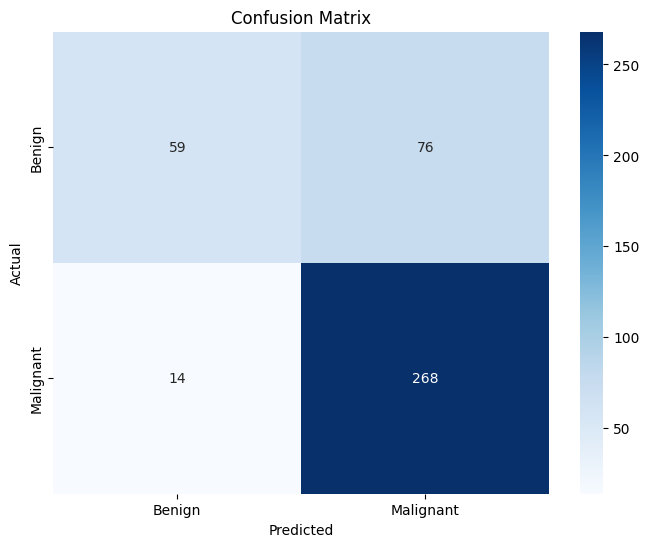

In [ ]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

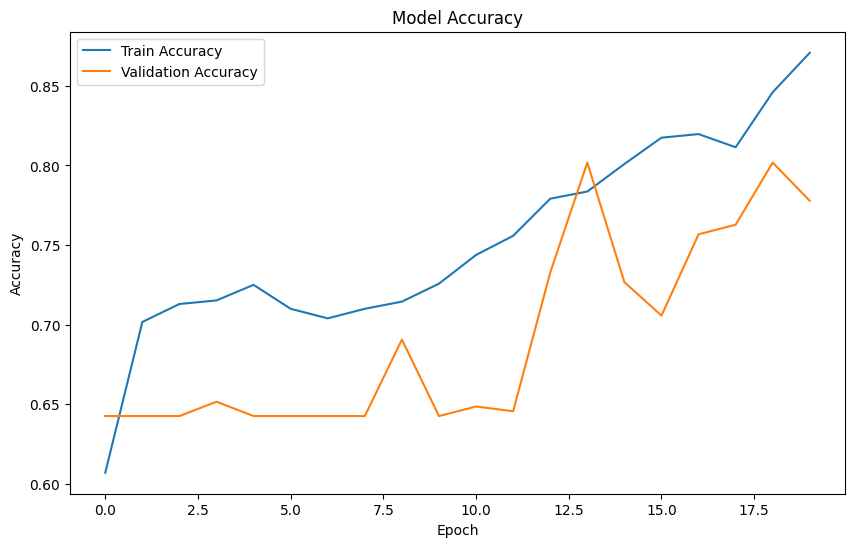

In [ ]:



# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


## **VGG16**

In [19]:
# Define VGG16 model for 128x128 input with fine-tuning
def create_vgg16(input_shape=(128, 128, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Allow fine-tuning

    # Freeze all layers except the last 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Use base model
    x = GlobalAveragePooling2D()(x)         # Pooling layer
    x = Dense(256, activation='relu')(x)    # Fully connected layer
    x = Dropout(0.2)(x)                     # Regularization
    outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and compile the fine-tuned VGG16 model
vgg16_model = create_vgg16()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Model Training**

In [20]:
# Train the VGG16 model
history = vgg16_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.6367 - loss: 0.7536 - val_accuracy: 0.6763 - val_loss: 0.5045
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7233 - loss: 0.4891 - val_accuracy: 0.8465 - val_loss: 0.3614
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8354 - loss: 0.3832 - val_accuracy: 0.7962 - val_loss: 0.4222
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8696 - loss: 0.3253 - val_accuracy: 0.8873 - val_loss: 0.2713
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9261 - loss: 0.1949 - val_accuracy: 0.9065 - val_loss: 0.2787
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.9176 - loss: 0.1782 - val_accuracy: 0.9089 - val_loss: 0.2293
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9324 - loss: 0.1621 - val_accuracy: 0.9113 - val_loss: 0.2802
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9708 - loss: 0.0841 - val_accuracy: 0.9041 -

### **Model Evalution**

In [21]:

# Evaluate the model
loss, accuracy = vgg16_model.evaluate(X_test, y_test)
print(f'VGG16 Test Accuracy: {accuracy:.2f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9062 - loss: 0.4792
VGG16 Test Accuracy: 0.91


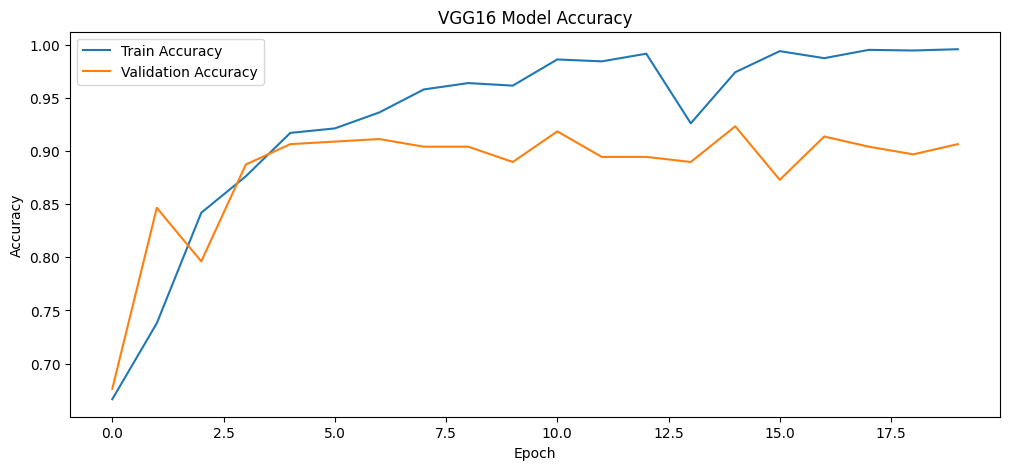

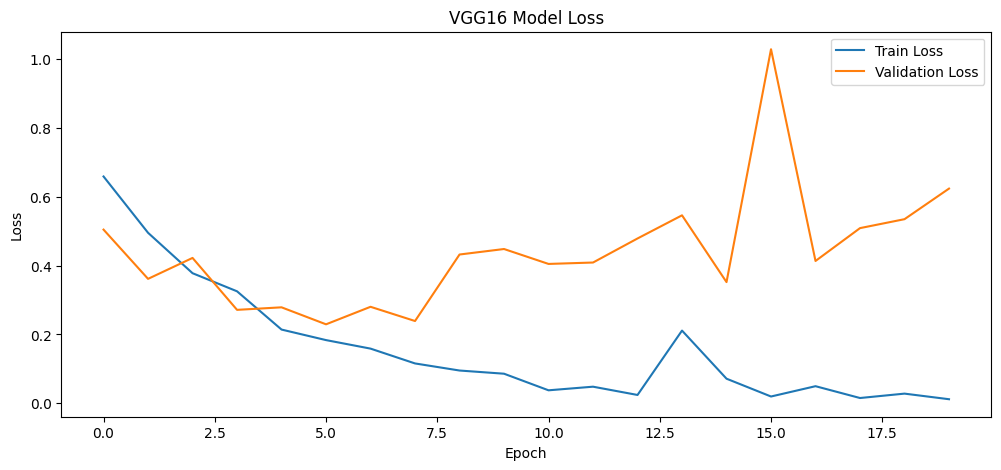

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step

VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       135
           1       0.91      0.96      0.93       282

    accuracy                           0.91       417
   macro avg       0.90      0.88      0.89       417
weighted avg       0.91      0.91      0.90       417



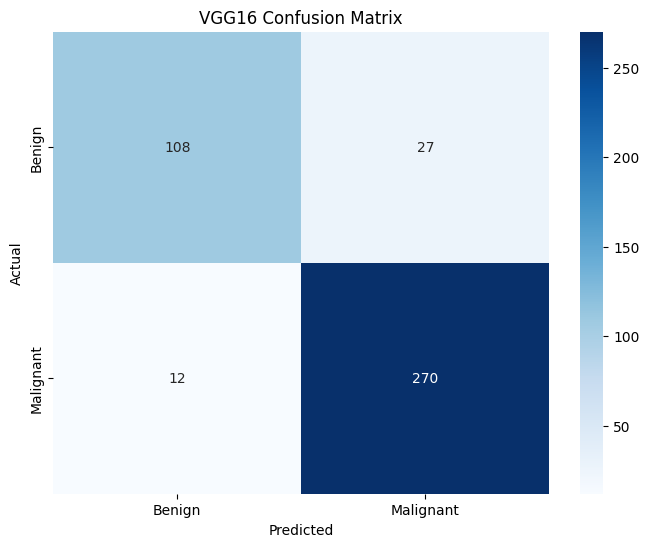

In [22]:

# Metrics and plots
def plot_metrics(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion matrix and classification report
    y_pred = (vgg16_model.predict(X_test) > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Plot metrics
plot_metrics(history, "VGG16")

## **RestNet**

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_resnet50(input_shape=(128, 128, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Unfreeze the base model
    # Freeze all layers up to the last 20 layers, for example
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)  # Increased dropout to avoid overfitting
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create and compile the ResNet50 model
resnet50_model = create_resnet50()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Model Training**

In [26]:
# Train ResNet50 model
resnet50_history = resnet50_model.fit(X_train, y_train, batch_size=32,
                                      validation_data=(X_test, y_test),
                                      epochs=20)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 221ms/step - accuracy: 0.6457 - loss: 0.7183 - val_accuracy: 0.6763 - val_loss: 0.6390
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6800 - loss: 0.6219 - val_accuracy: 0.5875 - val_loss: 0.6776
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7032 - loss: 0.5928 - val_accuracy: 0.4676 - val_loss: 0.6943
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6961 - loss: 0.5822 - val_accuracy: 0.6739 - val_loss: 0.6046
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6873 - loss: 0.5959 - val_accuracy: 0.4508 - val_loss: 0.7147
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7101 - loss: 0.5602 - val_accuracy: 0.6859 - val_loss: 0.6097
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7214 - loss: 0.5359 - val_accuracy: 0.6882 - val_loss: 0.5835
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7304 - loss: 0.5382 - val_accuracy: 0.6739 -

### **Model Evalution**

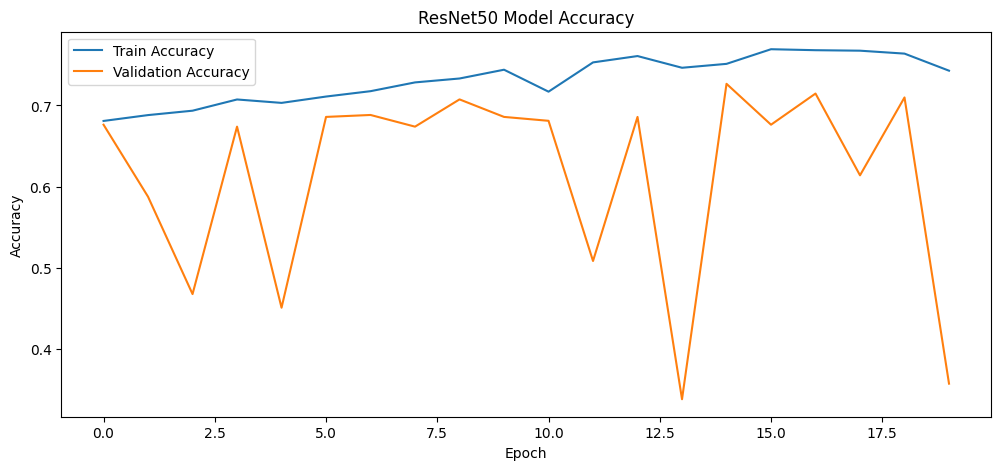

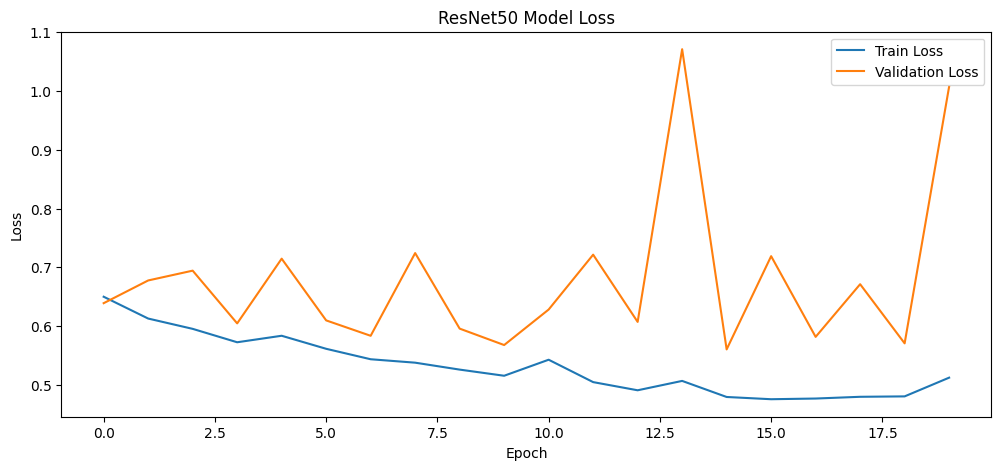

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot metrics
def plot_metrics(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot metrics for ResNet50
plot_metrics(resnet50_history, "ResNet50")


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step

<Functional name=functional_4, built=True> Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50       135
           1       1.00      0.05      0.09       282

    accuracy                           0.36       417
   macro avg       0.67      0.52      0.30       417
weighted avg       0.78      0.36      0.23       417



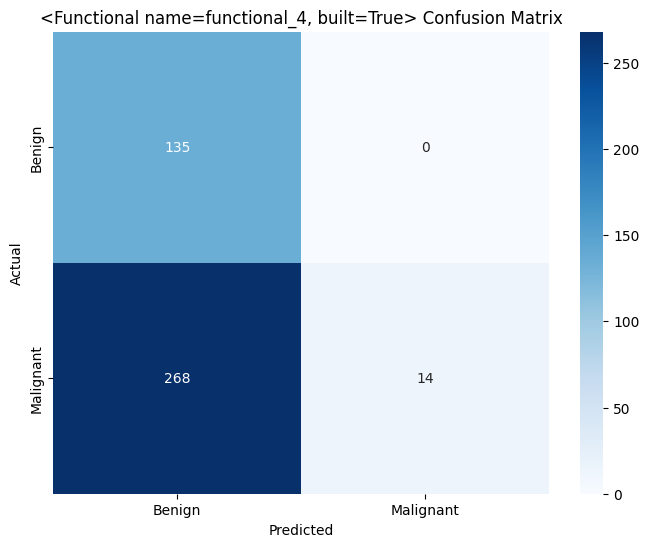

In [28]:
# Confusion matrix and classification report
y_pred = (resnet50_model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
print(f"\n{resnet50_model} Classification Report:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'{resnet50_model} Confusion Matrix')
plt.show()


## **MobileNet**

In [30]:

def create_mobilenet(input_shape=(128, 128, 3)):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [31]:
model_mobilenet=create_mobilenet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Model Training**

In [32]:
# Train the model
history_mobilenet = model_mobilenet.fit(X_train, y_train, batch_size=32,
                                      validation_data=(X_test, y_test),
                                      epochs=20)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.7106 - loss: 0.6584 - val_accuracy: 0.8657 - val_loss: 0.3588
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8900 - loss: 0.2975 - val_accuracy: 0.8513 - val_loss: 0.3442
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9209 - loss: 0.2161 - val_accuracy: 0.8729 - val_loss: 0.3076
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9390 - loss: 0.1769 - val_accuracy: 0.8753 - val_loss: 0.2987
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9610 - loss: 0.1207 - val_accuracy: 0.8657 - val_loss: 0.3110
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9751 - loss: 0.0992 - val_accuracy: 0.8681 - val_loss: 0.3180
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9834 - loss: 0.0869 - val_accuracy: 0.8825 - val_loss: 0.2968
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9934 - loss: 0.0496 - val_accuracy: 0.8705 -

### **Model Evalution**

In [ ]:

# Evaluate the model
loss, accuracy = model_mobilenet.evaluate(X_test, y_test)
print(f'MObilenet Test Accuracy: {accuracy:.2f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8978 - loss: 0.2616
MObilenet Test Accuracy: 0.90


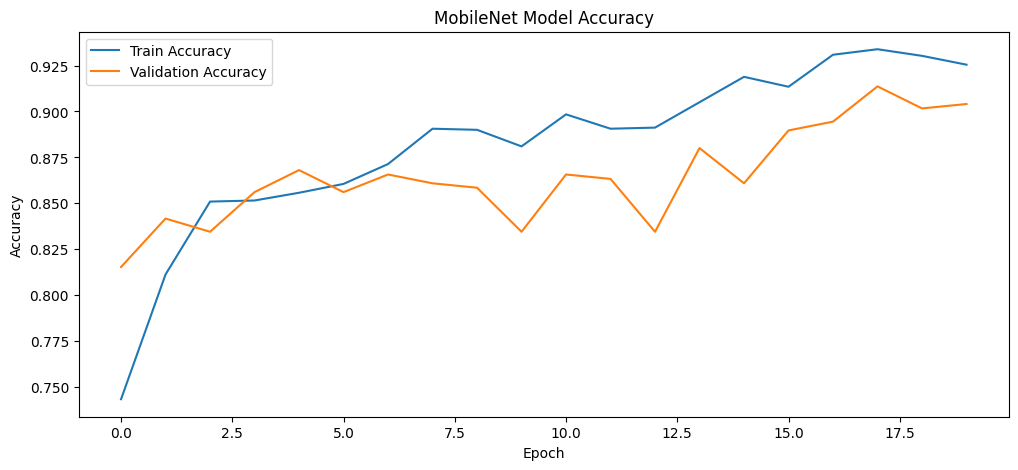

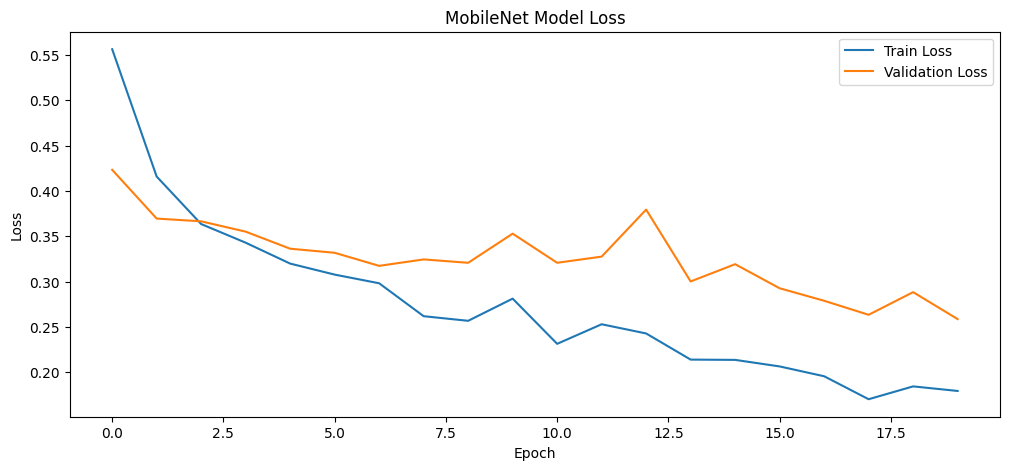

In [ ]:
plot_metrics(history_mobilenet, "MobileNet")


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step

<Functional name=functional_5, built=True> Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       135
           1       0.90      0.93      0.91       282

    accuracy                           0.88       417
   macro avg       0.87      0.86      0.86       417
weighted avg       0.88      0.88      0.88       417



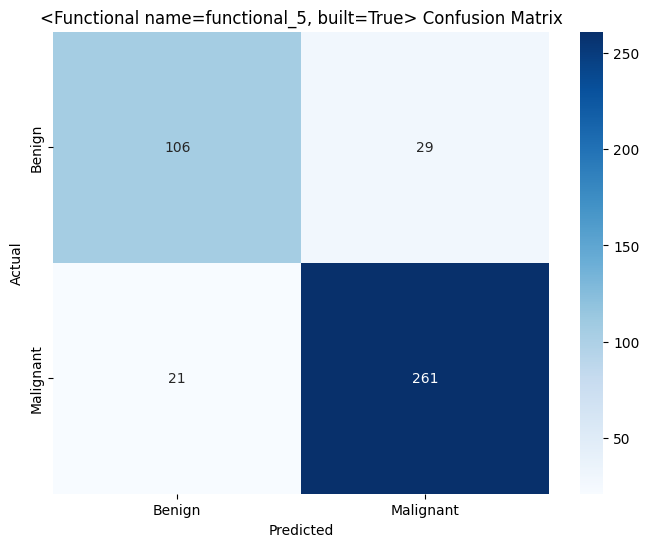

In [33]:
# Confusion matrix and classification report
y_pred = (model_mobilenet.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
print(f"\n{model_mobilenet} Classification Report:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'{model_mobilenet} Confusion Matrix')
plt.show()